In [1]:
import pathlib

In [2]:
import numpy as np

In [11]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 8)


In [4]:
import symlens
from symlens import qe

In [5]:
from pixell import enmap, utils as putils

In [6]:
import itertools

In [7]:
import utilities

In [8]:
directory = pathlib.Path('/scratch/r/rbond/omard/CORI17112020/extract_sehgal/LensQuEst-1/spectracmb/')

In [9]:
el, ilcpower = np.loadtxt(directory/'power_ilc.txt', unpack = True)

el, crossilcpower = np.loadtxt(directory/'crosspower_ilc_tszdepr.txt', unpack = True)

el, deprilcpower = np.loadtxt(directory/'power_ilc_tszdepr.txt', unpack = True)

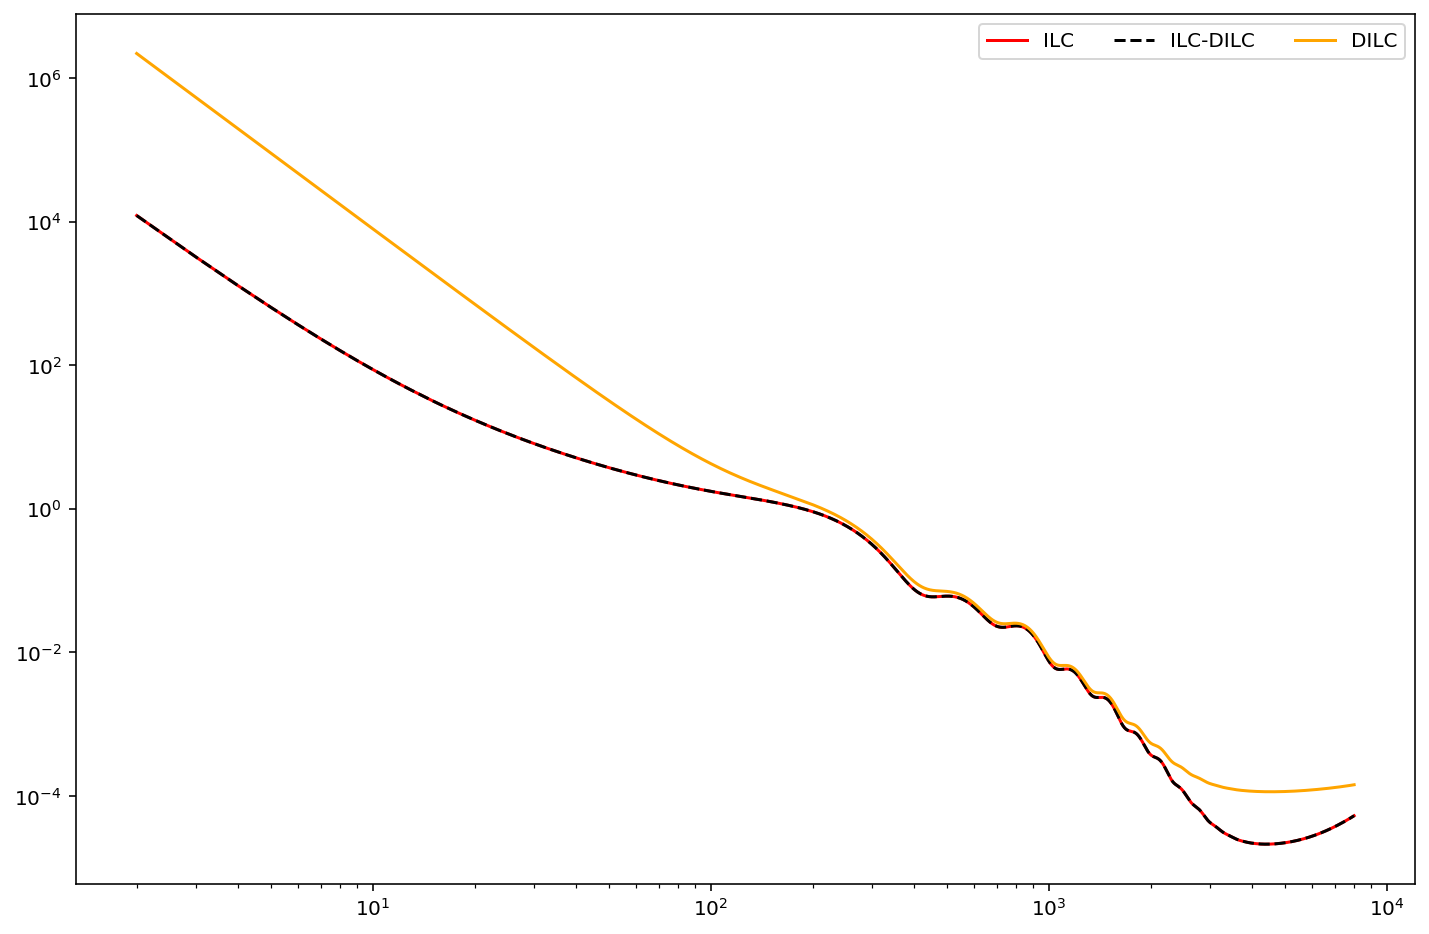

In [12]:
plt.plot(el, ilcpower, color = 'red', label = 'ILC')
plt.plot(el, crossilcpower, color = 'black', ls = '--', label = 'ILC-DILC')
plt.plot(el, deprilcpower, color = 'orange', label = 'DILC')
plt.legend(ncol = 3)
plt.yscale('log')
plt.xscale('log')

In [13]:
def interpolate(l, cl, modlmap):
        return  symlens.interp(l, cl)(modlmap)

def fft(mappa):
    return enmap.samewcs(enmap.fft(mappa, normalize = 'phys'), mappa)

In [14]:
class Estimator(object):
    def __init__(self, shape, wcs, feed_dict, estimator,
                 lmin, lmax,
                 field_names = None, groups = None, 
                 Lmin = 20, Lmax = 6000, 
                 hardening = None, XY = 'TT'):

        if hardening == '':
            hardening = None        

        xmask, ymask, kmask = self.get_masks(shape, wcs, xlmin = lmin, xlmax = lmax, xlx = None, xly = None,
                                             ylmin = lmin, ylmax = lmax, ylx = None, yly = None,
                                             Lmin = Lmin, Lmax = Lmax, Lx = None, Ly = None)

        self.fdict = feed_dict
            
        f, F, Fr = self.get_mc_expressions(estimator, XY = 'TT', field_names = field_names, estimator_to_harden = 'hu_ok', 
                           hardening = hardening, feed_dict = feed_dict, shape = shape, wcs = wcs, xmask = xmask, ymask = ymask, kmask = kmask)

        if estimator == 'symm':
            self.Al = xmask*0.+1.
        else:
            self.Al = self.A_l_custom(shape, wcs, feed_dict, f, F, 
                                  xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
        
        self.F = F
        self.f = f
        self.Fr = Fr

        self.xmask = xmask
        self.ymask = ymask
        self.kmask = kmask
        self.shape, self.wcs = shape, wcs

        self.field_names = field_names

        self.estimator = estimator

        self.XY = XY

    def get_masks(self, shape, wcs, xlmin, xlmax, xlx, xly,
                                    ylmin, ylmax, ylx, yly,
                                    Lmin, Lmax, Lx, Ly):
        xmask = self.get_mask(shape, wcs, xlmin, xlmax, xlx, xly)
        ymask = self.get_mask(shape, wcs, ylmin, ylmax, ylx, yly)
        kmask = self.get_mask(shape, wcs, Lmin, Lmax, Lx, Ly)
        return xmask, ymask, kmask

    def get_mask(self, shape, wcs, lmin, lmax, lx, ly):
        return symlens.mask_kspace(shape, wcs, lxcut = lx, lycut = ly, lmin = lmin, lmax = lmax)

    def A_l_custom(self, shape, wcs, feed_dict, f, F, xmask, ymask, 
                   groups = None,kmask = None):
        return symlens.A_l_custom(shape, wcs, feed_dict, f, F, 
                                  xmask = xmask, ymask = ymask, groups = None,kmask = kmask) 
    
    def reconstruct_other(self, map1, map2, field_names = None, estimator = None, F = None):
        feed_dict = self.fdict.copy()
         
        if field_names is None:
            field_names = self.field_names
            
        name1 = field_names[0]
        name2 = field_names[1]

        feed_dict[name1] = map1
        feed_dict[name2] = map2

        xname1, xname2 = name1+'_l1', name2+'_l2'
        groups = self._get_groups(self.estimator if estimator is None else estimator, noise = False)
        return self._reconstruct(feed_dict, xname = xname1, yname = xname2, F = F)
    
    
    def reconstruct_symm(self, map1, map2):
        recAB = self.reconstruct_other(map1, map2, self.field_names, estimator = 'hdv', F = self.F_phiA)
        reversed_field_names = self.field_names.copy()
        reversed_field_names.reverse()
        recBA = self.reconstruct_other(map2, map1, reversed_field_names, estimator = 'hdv', F = self.F_phiB)
        return self.fdict['wA']*recAB+self.fdict['wB']*recBA
    
    
    def reconstruct(self, map1, map2):
        
        if self.estimator == 'symm':
            mappa = self.reconstruct_symm(map1, map2)
        else:
            mappa = self.reconstruct_other(map1, map2)
        return mappa
        


    def _reconstruct(self,feed_dict,xname ='X_l1',yname = 'Y_l2', groups = None, physical_units = True, F = None):
        uqe = symlens.unnormalized_quadratic_estimator_custom(self.shape,self.wcs,feed_dict,
                                                      self.F if F is None else F,xname = xname,yname = yname,
                                                      xmask = self.xmask,ymask = self.ymask,
                                                      groups = groups,physical_units = physical_units)
        return self.Al * uqe * self.kmask

    def get_Nl_cross(self, Estimator2, tipo = 't'):
        feed_dict = {**self.fdict, **Estimator2.fdict}
        
        if (self.estimator == 'symm') and (Estimator2.estimator == 'symm'):
            N_l_cross_i_j = self.Ncoadd
        
        elif (self.estimator == 'symm' and Estimator2.estimator != 'symm'):
            N_l_cross_i_j = self.get_Nl_cross_symm_with_asymm(feed_dict, self, Estimator2, tipo)   
        
        elif (self.estimator != 'symm' and Estimator2.estimator == 'symm'):
            N_l_cross_i_j = self.get_Nl_cross_symm_with_asymm(feed_dict, Estimator2, self, tipo)
            
        else:
            N_l_cross_i_j= self.get_Nl_cross_other(feed_dict, Estimator2, tipo = tipo)
            
    
        return N_l_cross_i_j
    
    
    def get_Nl_cross_symm_with_asymm(self, feed_dict, EstimatorSymm, EstimatorStd, tipo = 't'):
        
        NLA = self.N_l_cross_custom(EstimatorSymm.shape, EstimatorSymm.wcs, feed_dict, EstimatorSymm.XY, EstimatorStd.XY, EstimatorSymm.F_phiA, EstimatorStd.F, EstimatorStd.Fr,
                                                xmask = EstimatorSymm.xmask*EstimatorStd.xmask, ymask = EstimatorSymm.ymask*EstimatorStd.ymask,
                                                field_names_alpha = EstimatorSymm.field_names, field_names_beta = EstimatorStd.field_names,
                                                falpha = EstimatorSymm.f_phiA, fbeta = EstimatorStd.f, Aalpha = EstimatorSymm.Al, Abeta = EstimatorStd.Al,
                                                groups = self._get_groups('hdv', EstimatorStd.estimator), kmask = EstimatorSymm.kmask*EstimatorStd.kmask,
                                                power_name = tipo)   

        NLB = self.N_l_cross_custom(EstimatorSymm.shape, EstimatorSymm.wcs, feed_dict, EstimatorSymm.XY, EstimatorStd.XY, EstimatorSymm.F_phiB, EstimatorStd.F, EstimatorStd.Fr,
                                                xmask = EstimatorSymm.xmask*EstimatorStd.xmask, ymask = EstimatorSymm.ymask*EstimatorStd.ymask,
                                                field_names_alpha = EstimatorSymm.field_names_r, field_names_beta = EstimatorStd.field_names,
                                                falpha = EstimatorSymm.f_phiB, fbeta = EstimatorStd.f, Aalpha = EstimatorSymm.Al, Abeta = EstimatorStd.Al,
                                                groups = self._get_groups('hdv', EstimatorStd.estimator), kmask = EstimatorSymm.kmask*EstimatorStd.kmask,
                                                power_name = tipo)
        
        result = NLA*EstimatorSymm.fdict['wA']+NLB*EstimatorSymm.fdict['wB']
            
        return result
    
    def get_Nl_cross_other(self, feed_dict, Estimator2, tipo = 't'):
        
        N_l_cross_i_j = self.N_l_cross_custom(self.shape, self.wcs, feed_dict, self.XY, Estimator2.XY, self.F, Estimator2.F, Estimator2.Fr,
                                                    xmask = self.xmask*Estimator2.xmask, ymask = self.ymask*Estimator2.ymask,
                                                    field_names_alpha = self.field_names, field_names_beta = Estimator2.field_names,
                                                    falpha = self.f, fbeta = Estimator2.f, Aalpha = self.Al, Abeta = Estimator2.Al,
                                                    groups = self._get_groups(self.estimator, Estimator2.estimator), kmask = self.kmask*Estimator2.kmask,
                                                    power_name = tipo)

        return N_l_cross_i_j


    def N_l_cross_custom(self, shape, wcs, feed_dict, alpha_XY, beta_XY, Falpha, Fbeta, Fbeta_rev,
                        xmask = None, ymask = None,
                        field_names_alpha = None, field_names_beta = None,
                        falpha = None, fbeta = None, Aalpha = None, Abeta = None,
                        groups = None, kmask = None, power_name = "t"):

        return symlens.N_l_cross_custom(shape, wcs, feed_dict, alpha_XY, beta_XY, Falpha, Fbeta, Fbeta_rev,
                        xmask = xmask, ymask = ymask,
                        field_names_alpha = field_names_alpha, field_names_beta = field_names_beta,
                        falpha = falpha, fbeta = fbeta, Aalpha = Aalpha, Abeta = Abeta,
                        groups = groups, kmask = kmask, power_name = power_name)
    

    def _get_groups(self, Estimator1, Estimator2 = None, noise = True):
        if Estimator2 is None:
            Estimator2 = Estimator1
        return qe._get_groups(Estimator1, Estimator2, noise = noise)
    
    def get_mc_expressions(self, estimator, XY = 'TT', field_names = None, estimator_to_harden = 'hu_ok', 
                           hardening = None, feed_dict = None, shape = None, wcs = None, xmask = None, ymask = None, kmask= None):
        
        if hardening is not None:
            f_phi, F_phi, Fr_phi = self.get_mc_expressions('hu_ok', field_names = field_names)
            f_bias, F_bias, _ = self.get_mc_expressions(hardening, field_names = field_names)
            f_bh, F_bh, Fr_bh = self.get_mc_expressions(f'{hardening}-hardened', estimator_to_harden = 'hu_ok', field_names = field_names)
            # 1 / Response of the biasing agent to the biasing agent
            self.fdict[f'A{hardening}_{hardening}_L'] = self.A_l_custom(shape, wcs, feed_dict, f_bias, F_bias,
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
            # 1 / Response of the biasing agent to CMB lensing
            self.fdict[f'Aphi_{hardening}_L'] = self.A_l_custom(shape, wcs, feed_dict, f_phi, F_bias,
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)

            f, F, Fr = f_bh, F_bh, Fr_bh
            
        elif estimator == 'symm':
            
            f_phiA, F_phiA, Fr_phiA = self.get_mc_expressions('hdv', field_names = field_names)
            
            field_names_r = field_names.copy()
            field_names_r.reverse()
            
            self.field_names_r = field_names_r
            
            f_phiB, F_phiB, Fr_phiB = self.get_mc_expressions('hdv', field_names = field_names_r)
            
            
            self.f_phiA, self.F_phiA, self.Fr_phiA = f_phiA, F_phiA, Fr_phiA
            self.f_phiB, self.F_phiB, self.Fr_phiB = f_phiB, F_phiB, Fr_phiB
    
            AA = self.A_l_custom(shape, wcs, feed_dict, f_phiA, F_phiA,
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
                    
            AB = self.A_l_custom(shape, wcs, feed_dict, f_phiB, F_phiB,
                                                        xmask = xmask, ymask = ymask, groups = None, kmask = kmask)
                                    
            NA = self.N_l_cross_custom(shape, wcs, feed_dict, XY, XY, F_phiA, F_phiA, Fr_phiA,
                                     xmask = xmask, ymask = ymask, field_names_alpha = field_names, field_names_beta = field_names,
                                     falpha = f_phiA, fbeta = f_phiA,
                                     Aalpha = AA, Abeta = AA, groups = None, kmask = kmask)
            
            NB = self.N_l_cross_custom(shape, wcs, feed_dict, XY, XY, F_phiB, F_phiB, Fr_phiB,
                                     xmask = xmask, ymask = ymask, field_names_alpha = field_names_r, field_names_beta = field_names_r,
                                     falpha = f_phiB, fbeta = f_phiB,
                                     Aalpha = AB, Abeta = AB, groups = None, kmask = kmask)
            
            
            NAB = self.N_l_cross_custom(shape, wcs, feed_dict, XY, XY, F_phiA, F_phiB, Fr_phiB,
                                     xmask = xmask, ymask = ymask, field_names_alpha = field_names, field_names_beta = field_names_r,
                                     falpha = f_phiA, fbeta = f_phiB,
                                     Aalpha = AA, Abeta = AB, groups = None, kmask = kmask)
            
            wA, wB = getasymmweights(NA, NB, NAB)
            
            self.Ncoadd = getcoaddednoise(NA, NB, NAB)
            
            f = f_phiA
            
            F = symlens.e('wA')*F_phiA+symlens.e('wB')*F_phiB
            Fr = symlens.e('wA')*Fr_phiA+symlens.e('wB')*Fr_phiB
            
            self.fdict['wA'] = wA*AA   #NOTE HERE DEFINITION OF WEIGHT
            self.fdict['wB'] = wB*AB
            
        else:
            f_phi, F_phi, Fr_phi = symlens.get_mc_expressions(estimator, XY, field_names, estimator_to_harden)
            f, F, Fr = f_phi, F_phi, Fr_phi

        
        return f, F, Fr

In [15]:
def getasymmweights(N_E1_E2, N_E2_E1, N_E1_E2_E2_E1):
    w_E1_E2 = N_E2_E1-N_E1_E2_E2_E1
    w_E2_E1 = N_E1_E2-N_E1_E2_E2_E1
    w = N_E1_E2+N_E2_E1-2*N_E1_E2_E2_E1
    w_E1_E2 /= w
    w_E2_E1 /= w
    return np.nan_to_num(w_E1_E2), np.nan_to_num(w_E2_E1)

def getcoaddedmap(map_E1_E2, map_E2_E1, N_E1_E2, N_E2_E1, N_E1_E2_E2_E1):
    w = N_E1_E2+N_E2_E1-2*N_E1_E2_E2_E1
    coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w
    w_E1_E2, w_E2_E1 = getasymmweights(N_E1_E2, N_E2_E1, N_E1_E2_E2_E1)
    kappatot = np.nan_to_num(w_E1_E2)*map_E1_E2+np.nan_to_num(w_E2_E1)*map_E2_E1
    return kappatot

def getcoaddednoise(N_E1_E2, N_E2_E1, N_E1_E2_E2_E1):
    w = N_E1_E2+N_E2_E1-2*N_E1_E2_E2_E1
    coadd_noise = (N_E1_E2*N_E2_E1-N_E1_E2_E2_E1**2.)/w
    return np.nan_to_num(coadd_noise)

In [16]:
def load_load_spectra(dictionary):
    def load_spectra(A, B):
        return dictionary[A+B]
    return load_spectra

In [17]:
def Loadfeed_dict_function(ells, load_spectra, field_names_A, field_names_B, modlmap):

    field_names = field_names_A+field_names_B
    all_combs = list(itertools.combinations_with_replacement(list(field_names), 2))

    
    ctt = load_spectra('uCMB', 'uCMB')
    ctt_lensed = load_spectra('lCMB', 'lCMB')
    
    logTT = np.log(ctt)

    theory2dps_lensed_CMB = interpolate(ells, ctt_lensed, modlmap)
    theory2dps_unlensed_CMB = interpolate(ells, ctt, modlmap)
    grad_theory2dps_unlensed_CMB = interpolate(ells, np.gradient(logTT, np.log(ells)), modlmap)
    
    #total2dB = interpolate(ells, fftotB, modlmap)
    #total2dAB = interpolate(ells, fftotAB, modlmap)
    
    feed_dict = {}
    
    feed_dict['uC_T_T'] = theory2dps_unlensed_CMB
    feed_dict['duC_T_T'] = grad_theory2dps_unlensed_CMB    
    feed_dict['pc_T_T'] = 1.   

    for A, B in all_combs:
        
        strA = f'_{A}' if A != '' else ''
        strB = f'_{B}' if B != '' else ''
        
        feed_dict[f'tC{strA}_T{strB}_T'] = interpolate(ells, load_spectra(A, B), modlmap)
    
    return feed_dict

In [18]:
field_names_A = ['ilc', 'ilcdepr']
field_names_B = ['ilcdepr', 'ilc']

In [19]:
ell, clunlen, cllen, ftot, _, _, clftszmanu = np.loadtxt(directory.parent/'spectra_lensqest_un_len_detectnoise_fftot_fg_ftSZ.txt', unpack = True)

In [36]:
logTT = np.log(clunlen)

theory2dps_lensed_CMB = interpolate(ell, cllen, modlmap)
theory2dps_unlensed_CMB = interpolate(ell, clunlen, modlmap)
grad_theory2dps_unlensed_CMB = interpolate(ell, np.gradient(logTT, np.log(ell)), modlmap)

feed_dictH = {}

feed_dictH['uC_T_T'] = theory2dps_unlensed_CMB
feed_dictH['duC_T_T'] = grad_theory2dps_unlensed_CMB    
feed_dictH['pc_T_T'] = 1.   
feed_dictH['tC_X_T_X_T'] = interpolate(ell, ftot, modlmap)

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [21]:
dictionary = {}
dictionary['ilcilc'] = ilcpower
dictionary['ilcdeprilcdepr'] = deprilcpower
dictionary['ilcilcdepr'] = crossilcpower
dictionary['ilcdeprilc'] = crossilcpower
dictionary['uCMBuCMB'] = np.interp(el, ell, clunlen)
dictionary['lCMBlCMB'] = np.interp(el, ell, cllen)

In [22]:
field_names_hu_ok = ['ilc', 'ilc']

In [23]:
dictionary_hu_ok = {}
dictionary_hu_ok['ilcilc'] = ilcpower
dictionary_hu_ok['uCMBuCMB'] = np.interp(el, ell, clunlen)
dictionary_hu_ok['lCMBlCMB'] = np.interp(el, ell, cllen)

In [24]:
load_spectra = load_load_spectra(dictionary)

In [25]:
load_spectra_hu_ok = load_load_spectra(dictionary_hu_ok)

In [26]:
nuA = ['ilc', 'ilc_depr']
nuB = ['ilc', 'ilc']

In [27]:
mapsObjA = utilities.mapNamesObj(nuA)
mapsObjB = utilities.mapNamesObj(nuB)

In [28]:
C = utilities.Converting()

In [29]:
sims_directory = '../extract_sehgal/manusmaps/flat_maps_large/latestmaps13092020/'
WR = utilities.write_read(sims_directory)

In [30]:
changemap = lambda x: enmap.enmap(x, wcs)
#Load maps for Leg1, Leg2 for estimator A
LoadA = utilities.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = utilities.fft)

In [31]:
fgnamefile = 'tsz'

In [65]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))

In [33]:
mapsObjA.fgtemplate(fgnamefile+'_'+str(LoadA.nu))

"sehgal_tsz_['ilc', 'ilc_depr']_large_cutout"

In [34]:
fgnamefile

'tsz'

In [160]:
fg_fft_masked_A1, fg_gaussian_fft_masked_A1, fg_fft_masked_A2, fg_gaussian_fft_masked_A2 = LoadA.read_fg_only(fgnamefile, num = 0)

tsz_ilc


In [35]:
modlmap = enmap.modlmap(shape,wcs)

In [162]:
feed_dict = Loadfeed_dict(el, load_spectra, field_names_A, field_names_B, modlmap)

In [163]:
feed_dict_hu_ok = Loadfeed_dict(el, load_spectra_hu_ok, field_names_hu_ok, field_names_hu_ok, modlmap)

In [164]:
E_depr_ilc = Estimator(shape, wcs, feed_dict, 'hdv',
                 30, 3500,
                 field_names = field_names_B, groups = None, 
                 Lmin = 20, Lmax = 6000, 
                 hardening = None, XY = 'TT')

E_ilc_depr = Estimator(shape, wcs, feed_dict, 'hdv',
                 30, 3500,
                 field_names = field_names_A, groups = None, 
                 Lmin = 20, Lmax = 6000, 
                 hardening = None, XY = 'TT')

In [165]:
E_symm = Estimator(shape, wcs, feed_dict, 'symm',
                 30, 3500,
                 field_names = field_names_A, groups = None, 
                 Lmin = 20, Lmax = 6000, 
                 hardening = None, XY = 'TT')

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [166]:
E_hu_ok = Estimator(shape, wcs, feed_dict_hu_ok, 'hu_ok',
                 30, 3500,
                 field_names = field_names_hu_ok, groups = None, 
                 Lmin = 20, Lmax = 6000, 
                 hardening = None, XY = 'TT')

In [167]:
#E_symm_copy = E_symm.copy()
N_symm = E_symm.get_Nl_cross(E_hu_ok)

In [168]:
Nl_depr_ilc = E_depr_ilc.get_Nl_cross(E_depr_ilc)
Nl_ilc_depr = E_ilc_depr.get_Nl_cross(E_ilc_depr)

Nl_depr_ilc_ilc_depr = E_depr_ilc.get_Nl_cross(E_ilc_depr)


In [169]:
Nl_depr_cross = E_depr_ilc.get_Nl_cross(E_hu_ok)
Nl_ilc_cross = E_ilc_depr.get_Nl_cross(E_hu_ok)
w1, w2 = getasymmweights(Nl_depr_ilc, Nl_ilc_depr, Nl_depr_ilc_ilc_depr)

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [170]:
Ncross = w1*Nl_depr_cross+w2*Nl_ilc_cross

In [171]:
Nhuok = E_hu_ok.get_Nl_cross(E_hu_ok)

In [172]:
B = utilities.Binner(shape, wcs, lmin = 10, lmax = 4000, deltal = 40, log = False, nBins = 20)

In [173]:
l, ndilc = B.bin_spectra(Nl_depr_ilc)
l, nilcd = B.bin_spectra(Nl_ilc_depr)
l, ncross = B.bin_spectra(Nl_depr_ilc_ilc_depr)

In [174]:
l, nhuok = B.bin_spectra(Nhuok)

In [175]:
Ncoadd = getcoaddednoise(Nl_depr_ilc, Nl_ilc_depr, Nl_depr_ilc_ilc_depr)
l, ncoadd = B.bin_spectra(Ncoadd)

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [176]:
l, nsymm = B.bin_spectra(N_symm)

In [177]:
l, ncross_est = B.bin_spectra(Ncross)

In [178]:
def forplotting(l, cl, threshold = 0.):
    positivemask = cl>=threshold
    clp = cl[positivemask]
    lp = l[positivemask]
    cln = cl[~positivemask]
    ln = l[~positivemask]
    cln = abs(cln)
    return np.append(ln[-1], lp), np.append(cln[-1], clp), ln, cln

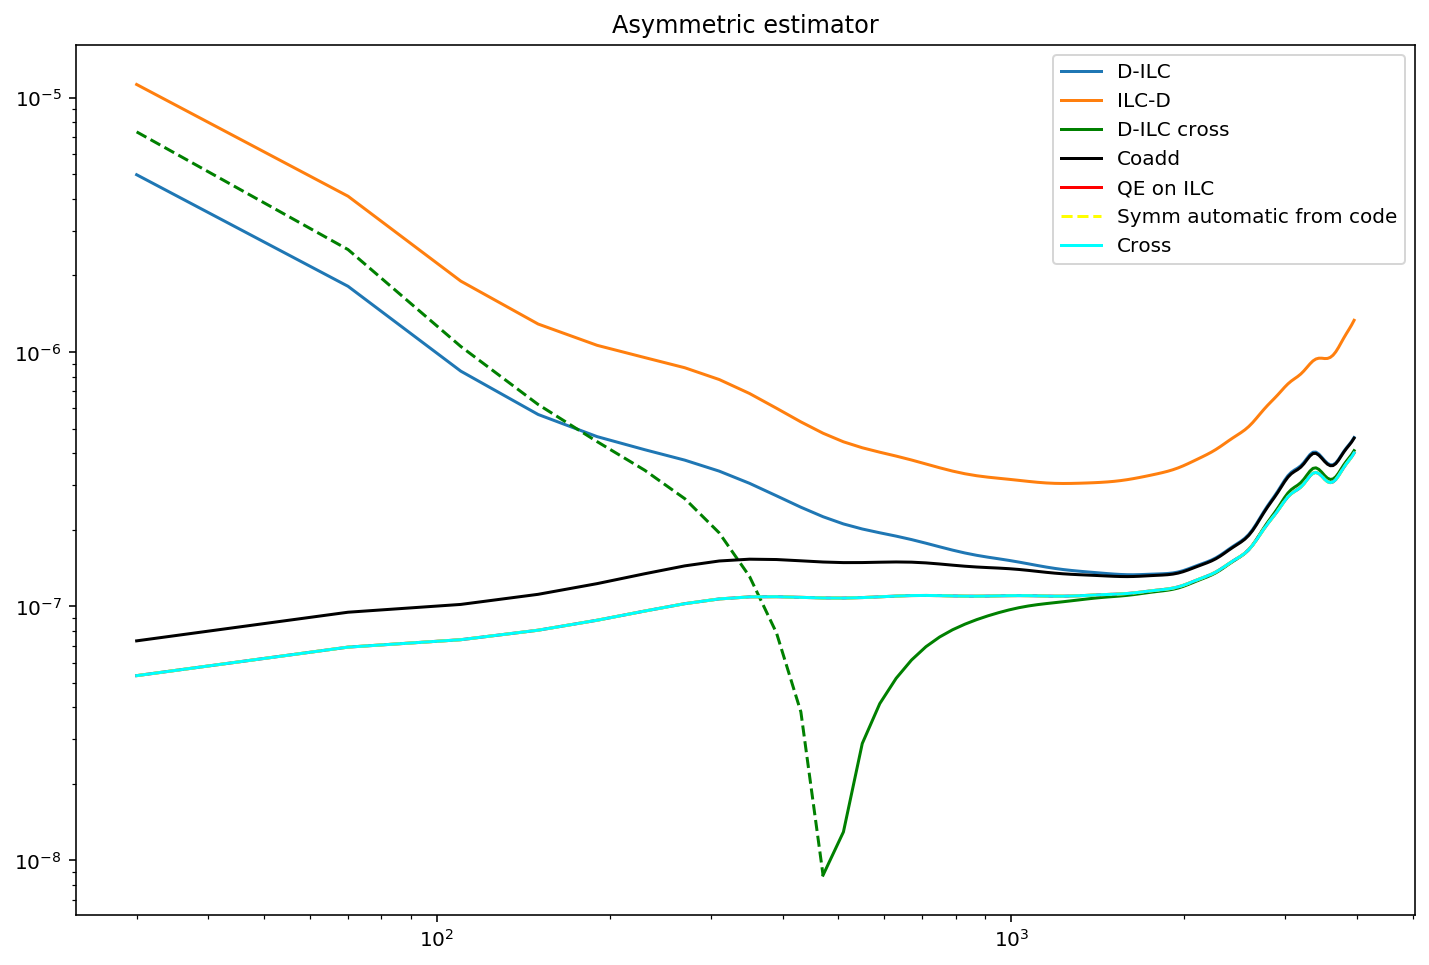

In [179]:
P = utilities.Plotting('Asymmetric', lminplot = 30, lmaxplot = 5000, xscale = 'log', yscale = 'log')

plt.title('Asymmetric estimator')

P.plot(l, ndilc, label = 'D-ILC')
P.plot(l, nilcd, label = 'ILC-D')

lp, clp, ln, cln = forplotting(l, ncross)
P.plot(lp, clp, label = 'D-ILC cross', color = 'green')
P.plot(ln, cln, ls = '--', color = 'green')

P.plot(l, ncoadd, label = 'Coadd', color = 'black')

P.plot(l, nhuok, label = 'QE on ILC', color = 'red')

P.plot(l, nsymm, label = 'Symm automatic from code', ls = '--', color = 'yellow')

P.plot(l, ncross_est, label = 'Cross', color = 'cyan')

P.set_scales()
plt.legend()

In [180]:
#fg_fft_masked_A1, fg_gaussian_fft_masked_A1, fg_fft_masked_A2, fg_gaussian_fft_masked_A2

In [189]:
rec_hu_ok_ilc_depr = E_hu_ok.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)
rec_hu_ok_depr_depr = E_hu_ok.reconstruct(fg_fft_masked_A2, fg_fft_masked_A2)
rec_hu_ok_ilc_ilc = E_hu_ok.reconstruct(fg_fft_masked_A1, fg_fft_masked_A1)

In [191]:
rec12_ilc_depr = E_depr_ilc.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)
rec12_depr_ilc = E_depr_ilc.reconstruct(fg_fft_masked_A2, fg_fft_masked_A1) #correct one

In [192]:
rec21_ilc_depr = E_ilc_depr.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2) #correct one
rec21_depr_ilc = E_ilc_depr.reconstruct(fg_fft_masked_A2, fg_fft_masked_A1)

In [201]:
recsymm = E_symm.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)

In [247]:
recsymmG = E_symm.reconstruct(fg_gaussian_fft_masked_A1, fg_gaussian_fft_masked_A2)

In [195]:
recsymm2 = E_symm.reconstruct(fg_fft_masked_A1, fg_fft_masked_A2)

In [197]:
w1, w2 = getasymmweights(Nl_depr_ilc, Nl_ilc_depr, Nl_depr_ilc_ilc_depr)

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [198]:
reccheck = w1*rec12_depr_ilc+w2*rec21_ilc_depr

In [253]:
l, rsymm = B.bin_maps(recsymm, recsymm, pixel_units = True)
l, rsymmG = B.bin_maps(recsymmG, pixel_units = True)
l, rcheck = B.bin_maps(reccheck, pixel_units = True)
l, rhu_ok_ilc_depr = B.bin_maps(rec_hu_ok_ilc_depr, pixel_units = True)
l, rhu_ok_ilc_ilc = B.bin_maps(rec_hu_ok_ilc_ilc, pixel_units = True)
l, rhu_ok_depr_depr = B.bin_maps(rec_hu_ok_depr_depr, pixel_units = True)

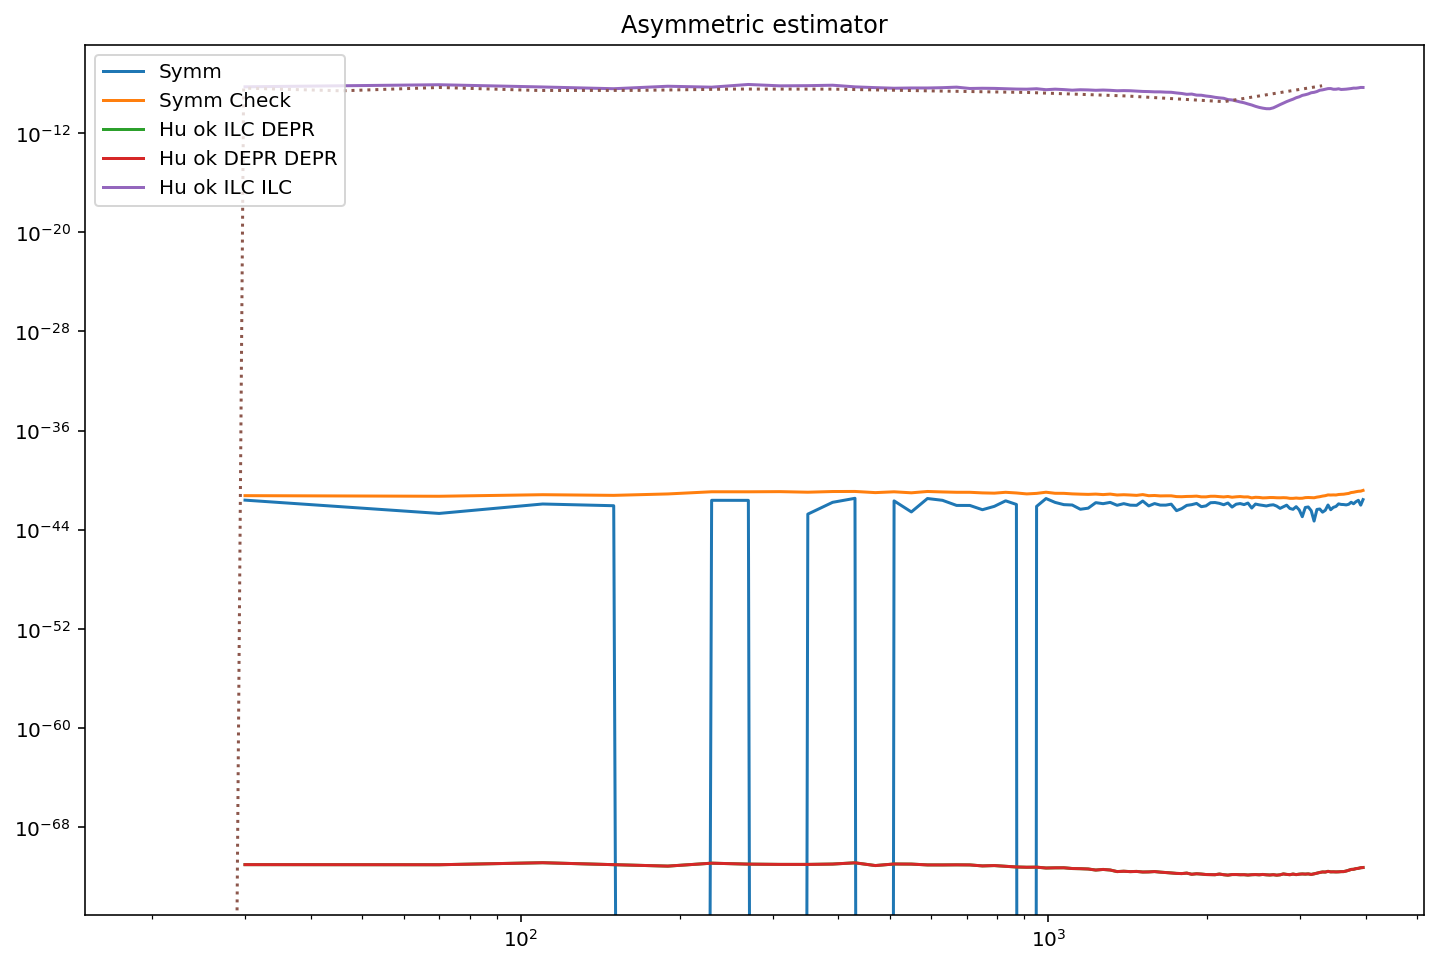

In [254]:
plt.title('Asymmetric estimator')

P.plot(l, rsymm-rsymmG, label = 'Symm')
P.plot(l, rcheck, label = 'Symm Check')

P.plot(l, rhu_ok_ilc_depr, label = 'Hu ok ILC DEPR')
P.plot(l, rhu_ok_depr_depr, label = 'Hu ok DEPR DEPR')
P.plot(l, rhu_ok_ilc_ilc, label = 'Hu ok ILC ILC')

P.plot(ells, dictionary_temp['T']['T-hu_ok-hu_ok'], ls = ':')

P.set_scales()
plt.legend()

In [220]:
dic = utilities.dictionary('/scratch/r/rbond/omard/CORI17112020/qelensingcomb/output_biases_ILC/', 'h3000s3000b3000sy3000')

In [239]:
fgnamefile = 'tsz'

In [240]:
i = 0
nu = 'ilc'
dictionary_temp = dic.read(f'{fgnamefile}_{nu}_{i}')

In [223]:
dictionary_temp.keys()

dict_keys(['N', 'T', 'P', 'S', 'PC', 'gg', 'kk', 'kg', 'ells'])

In [224]:
ells = dictionary_temp['ells']

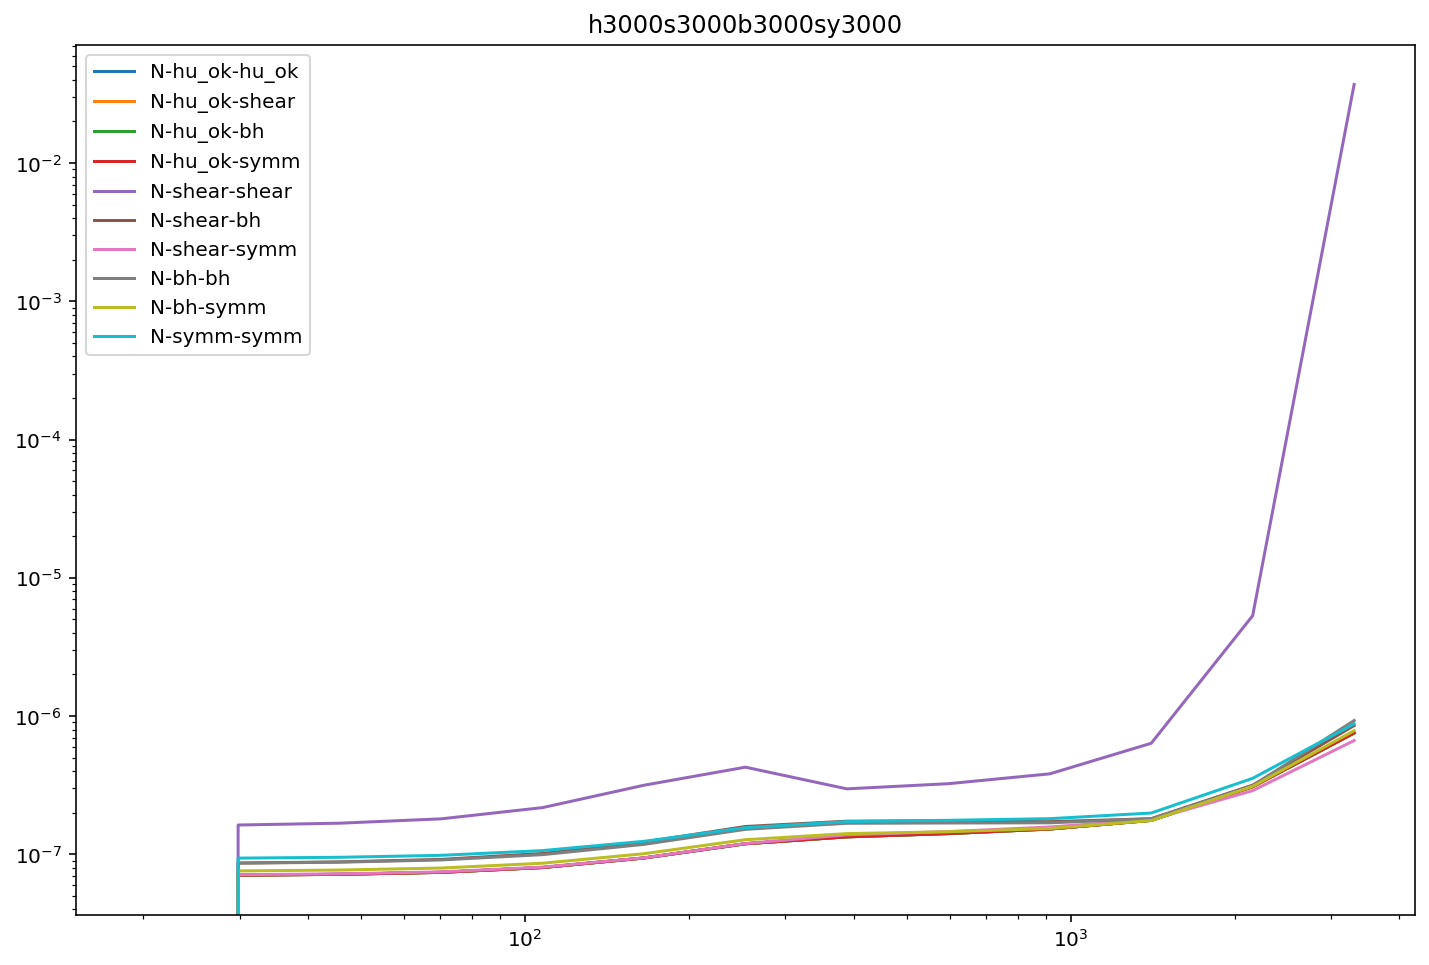

In [228]:
P = utilities.Plotting('Asymmetric', lminplot = 30, lmaxplot = 1000, xscale = 'log', yscale = 'log')
plt.title('h3000s3000b3000sy3000')
for k, e in dictionary_temp['N'].items():
    P.plot(ells, e, label = k)
plt.legend()
plt.yscale('log')
plt.xscale('log')

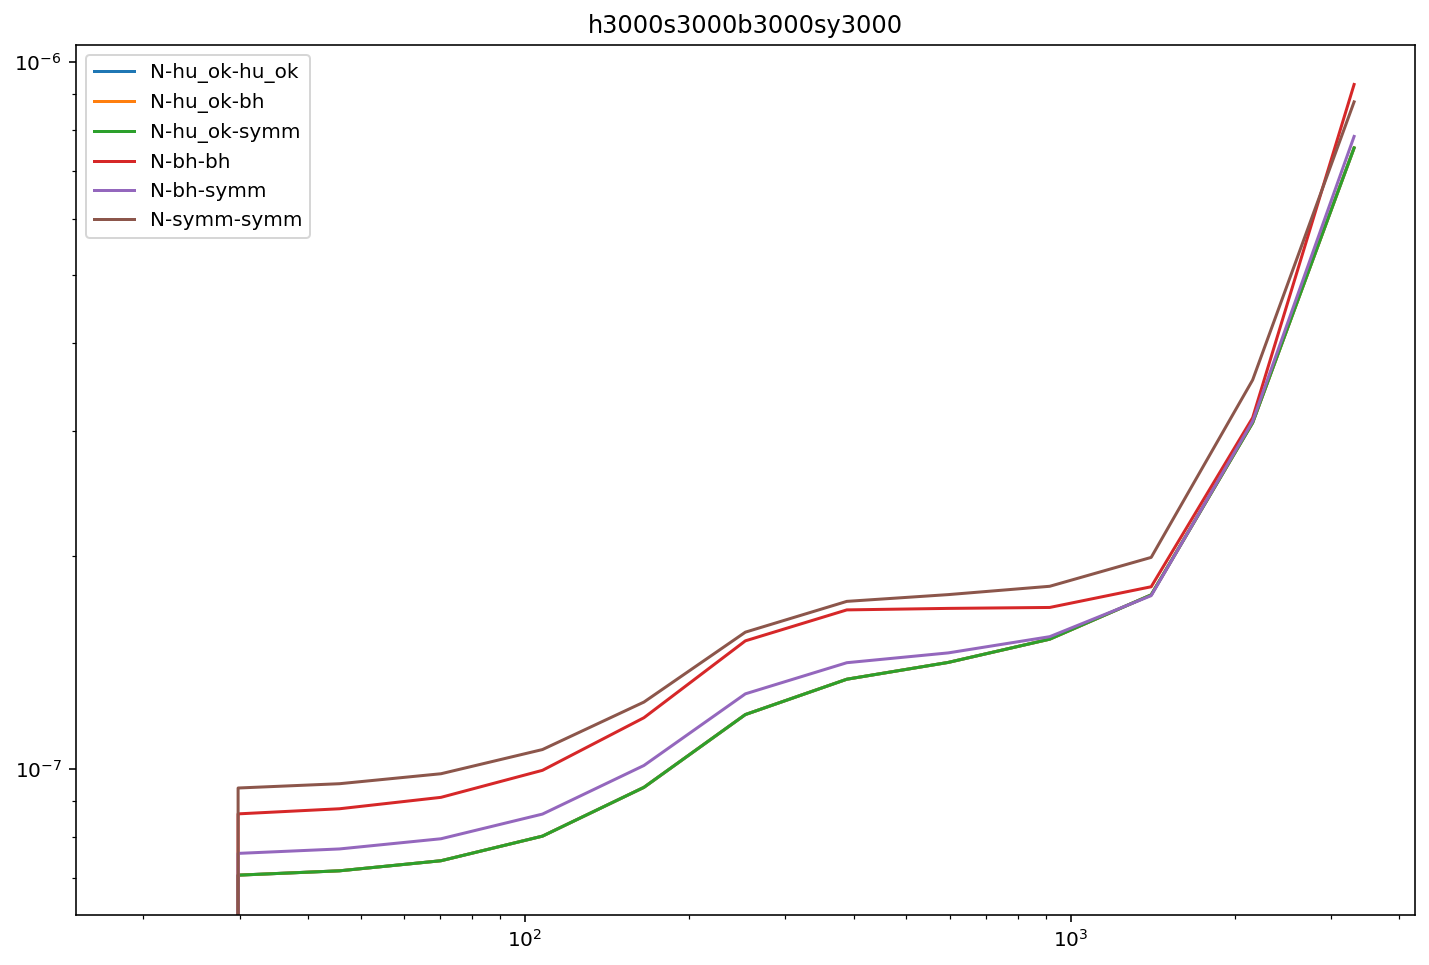

In [237]:
P = utilities.Plotting('Asymmetric', lminplot = 30, lmaxplot = 1000, xscale = 'log', yscale = 'log')
plt.title('h3000s3000b3000sy3000')
for k, e in dictionary_temp['N'].items():
    if not 'shear' in k:
        P.plot(ells, e, label = k)
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [283]:
cmb0_fft, cmb1_fft, fg_fft_masked_A1, fg_gaussian_fft_masked_A1, fg_fft_masked_A2, fg_gaussian_fft_masked_A2, kappa_fft_masked, gal_fft_map = LoadA.read_all(fgnamefile, num = 0)

tsz_ilc


In [83]:
changemap = lambda x: enmap.enmap(x, wcs)
#Load maps for Leg1, Leg2 for estimator A
mapsObj = utilities.mapNamesObj(148)

Load = utilities.LoadfftedMaps(mapsObj = mapsObj, WR = WR, ConvertingObj = C, changemap = changemap, getfft = utilities.fft)

In [84]:
Load.getfgfactor_for_manusmaps('tsz')

0.0017845037541339085

In [86]:
fgnamefile

'tsz'

In [85]:

cmb0_fft, cmb1_fft, fg_fft_masked_148, fg_gaussian_fft_masked_148, _, _, _, _ = Load.read_all(fgnamefile, num = 0)

KeyboardInterrupt: 

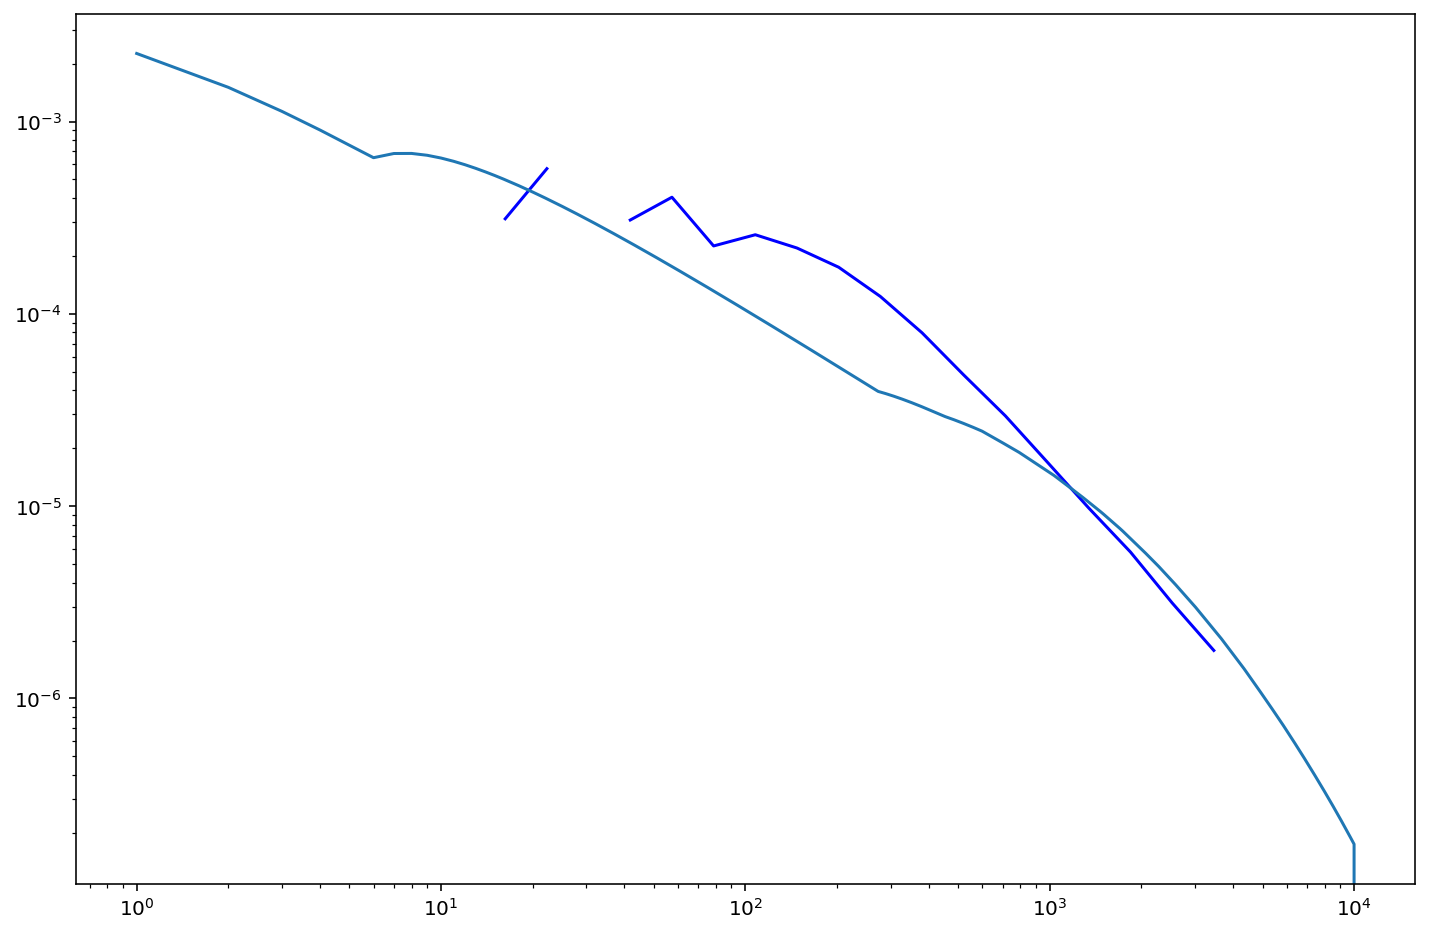

In [58]:
#el, fg1 = B.bin_maps(fg_fft_masked_A1, fg_fft_masked_A1, pixel_units = True)
#el, fg2 = B.bin_maps(fg_fft_masked_A2, fg_fft_masked_A2, pixel_units = True)

el, fg148 = B.bin_maps(fg_fft_masked_148, fg_fft_masked_148, pixel_units = True)

#plt.plot(el, fg1)
plt.plot(el, fg148, color = 'blue')
#plt.plot(el, fg2, ls = '--')

plt.plot(ell, clftszmanu)

plt.xscale('log')
plt.yscale('log')

In [37]:
import utilitiesold

In [38]:
E_hu_ok148 = utilitiesold.Estimator(shape, wcs, feed_dictH, 'shear',
                 30, 3500,
                 field_names = ['X', 'X'], groups = None, 
                 Lmin = 20, Lmax = 6000, 
                 hardening = None, XY = 'TT')

In [330]:
fg_fft_masked_A2 = fg_fft_masked_A1

In [337]:
mapS1 = E_hu_ok.reconstruct(cmb0_fft, fg_fft_masked_A2)
mapS1 = mapS1 + E_hu_ok.reconstruct(fg_fft_masked_A1, cmb0_fft)
mapS2 = E_hu_ok.reconstruct(cmb1_fft, fg_fft_masked_A2)
mapS2 = mapS2 + E_hu_ok.reconstruct(fg_fft_masked_A1, cmb1_fft)

In [338]:
el, secondary_A_B = B.bin_maps(mapS1, mapS2, pixel_units = True)
secondary_A_B *= 2

In [39]:
B = utilities.Binner(shape, wcs, lmin = 10, lmax = 4000, deltal = 40, log = True, nBins = 20)

In [40]:
mapsObj = utilitiesold.mapNamesObj(148)

Load = utilitiesold.LoadfftedMaps(mapsObj = mapsObj, WR = WR, ConvertingObj = C, changemap = changemap, getfft = utilities.fft)
cmb0_fft, cmb1_fft, fg_fft_masked_148, _, _, _, _, _ = Load.read_all(fgnamefile, num = 0)

In [41]:
mapS1 = E_hu_ok148.reconstruct(cmb0_fft, fg_fft_masked_148)
mapS1 = mapS1 + E_hu_ok148.reconstruct(fg_fft_masked_148, cmb0_fft)
mapS2 = E_hu_ok148.reconstruct(cmb1_fft, fg_fft_masked_148)
mapS2 = mapS2 + E_hu_ok148.reconstruct(fg_fft_masked_148, cmb1_fft)
el, secondary_A_B148 = B.bin_maps(mapS1, mapS2, pixel_units = True)
secondary_A_B148 *= 2

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [60]:
mapS1 = E_hu_ok148.reconstruct(fg_fft_masked_148, fg_fft_masked_148)
mapS2 = E_hu_ok148.reconstruct(fg_gaussian_fft_masked_148, fg_gaussian_fft_masked_148)

In [61]:
el, cl = B.bin_maps(mapS1, mapS1, pixel_units = True)
el, clg = B.bin_maps(mapS2, mapS2, pixel_units = True)
cl = cl-clg

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/utils.py:170: RuntimeWarning: invalid value encountered in true_divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


In [67]:
lCen, tris, prim, sec, _, _= np.loadtxt('/scratch/r/rbond/omard/CORI17112020/extract_sehgal/LensQuEst-1/out_txt/SH_3500.0_tris_prim_sec_0.txt', unpack = True)

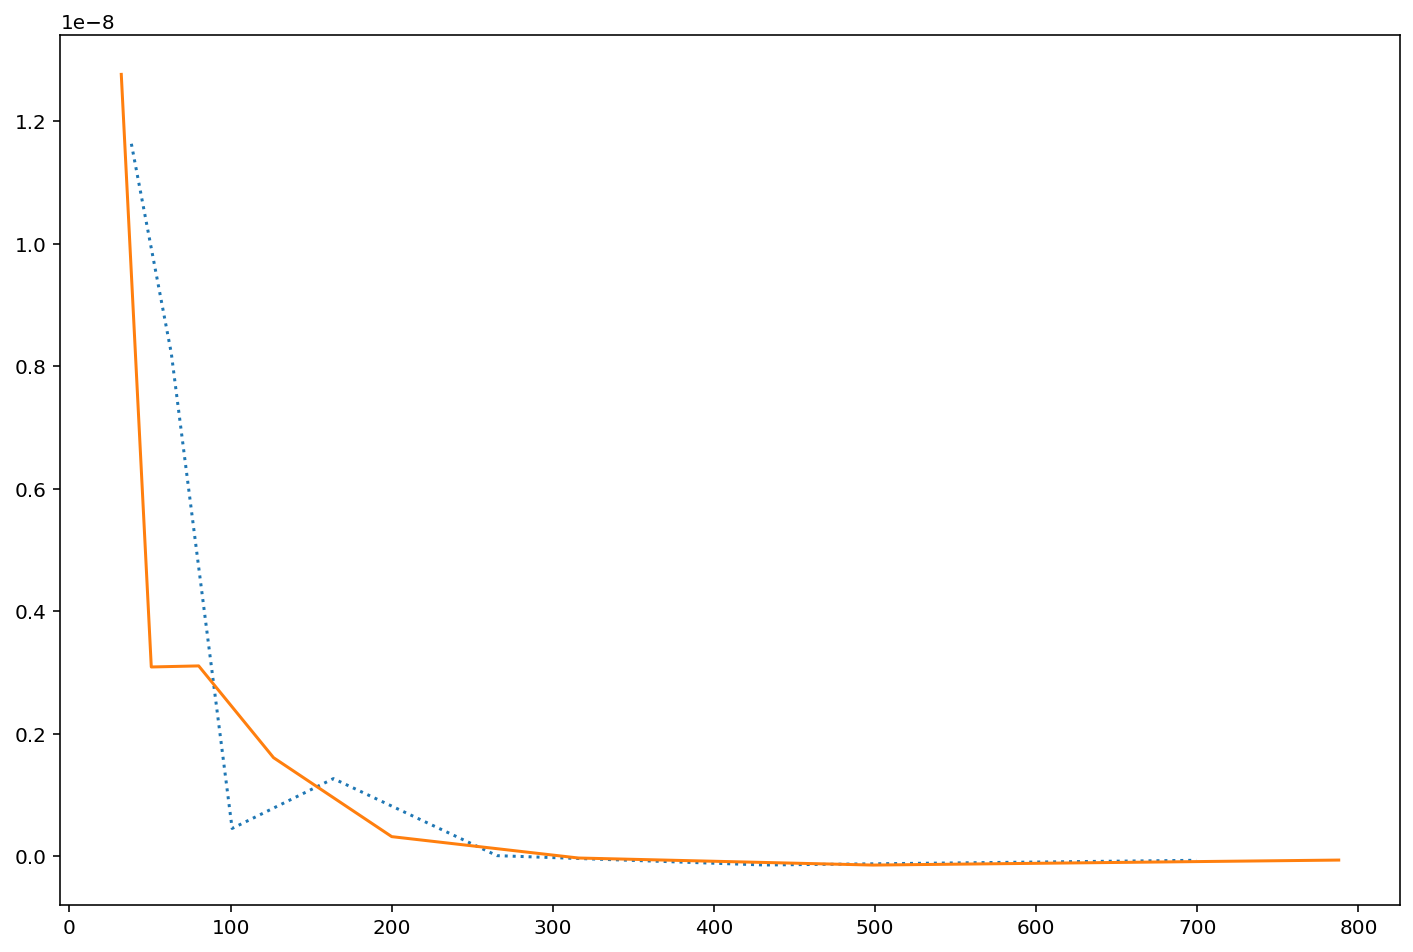

In [96]:
#plt.plot(el, secondary_A_B)
P = utilities.Plotting('Asymmetric', lminplot = 30, lmaxplot = 1000, xscale = 'log', yscale = 'log')

#P.plotsel(el, cl)
P.plotsel(lCen, prim, ls = ':')
#plt.plot(el, secondary_A_B148, ls = '--')
P.plotsel(dictionary_temp['ells'], dictionary_temp['P']['P-shear-shear'])

In [ ]:
utilities.Binner()

In [236]:
np.linspace(2500, 4500, 5, dtype = int)

array([2500, 3000, 3500, 4000, 4500])

In [255]:
dic = utilities.dictionary('/scratch/r/rbond/omard/CORI17112020/qelensingcomb/output_biases_ILC/', 'sy4500')

In [256]:
dictionary_temp = dic.read(f'tsz_{nu}_{i}')

In [257]:
dictionary_temp['T']

{'T-symm-symm': array([            nan,  0.00000000e+00, -3.08359946e-42,  4.20747991e-42,
         6.88715890e-43,  1.26986570e-42,  2.46362190e-43,  3.07944586e-42,
         2.34617738e-42,  1.95542443e-42,  1.91257002e-42,  1.19216545e-42,
         1.58253201e-42,  6.73811440e-43])}

In [88]:
dic = utilities.dictionary('/scratch/r/rbond/omard/CORI17112020/qelensingcomb/output_biases/', 'h3500s3500b3500')
dictionary_temp = dic.read(f'tsz_148_0')
dictionary_temp['P']

{'P-hu_ok-hu_ok': array([            nan,  0.00000000e+00, -6.88441311e-09, -1.00414745e-08,
        -1.35955030e-08, -4.05021418e-09, -5.59263969e-09, -3.20494923e-09,
        -2.24829075e-09, -1.31969138e-09, -5.17310299e-10, -1.28280858e-10,
         1.34423372e-10,  1.01090200e-09]),
 'P-hu_ok-shear': array([            nan,  0.00000000e+00,  2.94155214e-09, -3.47539149e-09,
        -5.24367194e-09, -1.22026048e-09, -2.63621531e-09, -1.61685765e-09,
        -1.19614563e-09, -6.91037261e-10, -2.94178077e-10, -1.10709400e-10,
         2.94318849e-10,  1.01004625e-09]),
 'P-hu_ok-bh': array([            nan,  0.00000000e+00, -4.92471392e-09, -6.25191725e-09,
        -7.55841726e-09, -1.71059846e-09, -3.13588371e-09, -1.90603876e-09,
        -1.49509859e-09, -9.27225544e-10, -3.39312710e-10, -9.37994649e-11,
         8.91468764e-11,  6.25474308e-10]),
 'P-shear-shear': array([            nan,  0.00000000e+00,  1.27675174e-08,  3.09069154e-09,
         3.10815914e-09,  1.60969322e-09,  

In [71]:
dic = utilities.dictionary('/scratch/r/rbond/omard/CORI17112020/qelensingcomb/output_biases_ILC/', 'h3500s3500b3500sy3500')
dictionary_temp = dic.read(f'tsz_{nu}_{i}')
dictionary_temp['S']

NameError: name 'nu' is not defined